In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

In [8]:
dataset_dir = "../data/new_data"   
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30

In [9]:
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 9332 files belonging to 34 classes.


In [10]:
class_names = dataset.class_names
print("Classes:", class_names)
num_classes = len(class_names)
print(num_classes)

Classes: ['African Violet (Saintpaulia ionantha)', 'Aloe Vera', 'Begonia (Begonia spp.)', 'Birds Nest Fern (Asplenium nidus)', 'Boston Fern (Nephrolepis exaltata)', 'Calathea', 'Cast Iron Plant (Aspidistra elatior)', 'Chinese Money Plant (Pilea peperomioides)', 'Christmas Cactus (Schlumbergera bridgesii)', 'Chrysanthemum', 'Ctenanthe', 'Dracaena', 'Elephant Ear (Alocasia spp.)', 'English Ivy (Hedera helix)', 'Hyacinth (Hyacinthus orientalis)', 'Iron Cross begonia (Begonia masoniana)', 'Jade plant (Crassula ovata)', 'Money Tree (Pachira aquatica)', 'Orchid', 'Parlor Palm (Chamaedorea elegans)', 'Peace lily', 'Poinsettia (Euphorbia pulcherrima)', 'Polka Dot Plant (Hypoestes phyllostachya)', 'Ponytail Palm (Beaucarnea recurvata)', 'Pothos (Ivy arum)', 'Prayer Plant (Maranta leuconeura)', 'Rattlesnake Plant (Calathea lancifolia)', 'Rubber Plant (Ficus elastica)', 'Sago Palm (Cycas revoluta)', 'Schefflera', 'Snake plant (Sanseviera)', 'Tradescantia', 'Tulip', 'Venus Flytrap']
34


In [5]:
import numpy as np
class_counts = {}
for images, labels in dataset:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1
print({class_names[k]: v for k,v in class_counts.items()})


{'Tulip': 299, 'Hyacinth (Hyacinthus orientalis)': 299, 'Rubber Plant (Ficus elastica)': 291, 'Begonia (Begonia spp.)': 234, 'Chinese Money Plant (Pilea peperomioides)': 299, 'Cast Iron Plant (Aspidistra elatior)': 266, 'Ponytail Palm (Beaucarnea recurvata)': 195, 'Dracaena': 260, 'Christmas Cactus (Schlumbergera bridgesii)': 299, 'Money Tree (Pachira aquatica)': 299, 'Polka Dot Plant (Hypoestes phyllostachya)': 299, 'Schefflera': 299, 'Sago Palm (Cycas revoluta)': 199, 'Chrysanthemum': 208, 'Jade plant (Crassula ovata)': 299, 'Birds Nest Fern (Asplenium nidus)': 290, 'Snake plant (Sanseviera)': 299, 'English Ivy (Hedera helix)': 240, 'Iron Cross begonia (Begonia masoniana)': 263, 'Rattlesnake Plant (Calathea lancifolia)': 299, 'Aloe Vera': 247, 'Peace lily': 299, 'Ctenanthe': 293, 'Boston Fern (Nephrolepis exaltata)': 296, 'Parlor Palm (Chamaedorea elegans)': 299, 'Venus Flytrap': 196, 'African Violet (Saintpaulia ionantha)': 298, 'Prayer Plant (Maranta leuconeura)': 299, 'Calathea': 

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])


In [14]:
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)


x = preprocess_input(x)

# --- Pretrained EfficientNetB3 base ---
base_model = EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_tensor=x
)

base_model.trainable = False 


In [15]:
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.4)(x)   # regularization
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = models.Model(inputs, outputs)

# --- Compile ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # ✅ lower LR
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,   # longer warmup
    verbose=1
)


Epoch 1/15
233/233 [==============================] - 187s 608ms/step - loss: 3.3727 - accuracy: 0.0993 - val_loss: 3.0057 - val_accuracy: 0.2651
Epoch 2/15
233/233 [==============================] - 177s 616ms/step - loss: 2.9257 - accuracy: 0.2466 - val_loss: 2.6055 - val_accuracy: 0.4149
Epoch 3/15
233/233 [==============================] - 192s 661ms/step - loss: 2.5886 - accuracy: 0.3580 - val_loss: 2.3423 - val_accuracy: 0.4688
Epoch 4/15
233/233 [==============================] - 193s 657ms/step - loss: 2.3444 - accuracy: 0.4258 - val_loss: 2.0540 - val_accuracy: 0.5765
Epoch 5/15
233/233 [==============================] - 176s 585ms/step - loss: 2.1604 - accuracy: 0.4758 - val_loss: 1.8871 - val_accuracy: 0.6013
Epoch 6/15
233/233 [==============================] - 172s 596ms/step - loss: 2.0095 - accuracy: 0.5110 - val_loss: 1.7760 - val_accuracy: 0.6261
Epoch 7/15
233/233 [==============================] - 195s 655ms/step - loss: 1.8898 - accuracy: 0.5384 - val_loss: 1.7030 -

In [17]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30  # unfreeze last 30 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1

)

Epoch 1/30
233/233 [==============================] - 202s 669ms/step - loss: 1.9011 - accuracy: 0.5349 - val_loss: 1.3322 - val_accuracy: 0.7037
Epoch 2/30
233/233 [==============================] - 175s 576ms/step - loss: 1.6895 - accuracy: 0.5963 - val_loss: 1.2764 - val_accuracy: 0.7155
Epoch 3/30
233/233 [==============================] - 165s 564ms/step - loss: 1.5232 - accuracy: 0.6333 - val_loss: 1.1342 - val_accuracy: 0.7522
Epoch 4/30
233/233 [==============================] - 165s 565ms/step - loss: 1.3942 - accuracy: 0.6656 - val_loss: 1.0200 - val_accuracy: 0.7620
Epoch 5/30
233/233 [==============================] - 164s 559ms/step - loss: 1.2911 - accuracy: 0.6832 - val_loss: 0.9381 - val_accuracy: 0.7812
Epoch 6/30
233/233 [==============================] - 166s 569ms/step - loss: 1.2006 - accuracy: 0.6965 - val_loss: 0.8523 - val_accuracy: 0.7899
Epoch 7/30
233/233 [==============================] - 167s 570ms/step - loss: 1.1267 - accuracy: 0.7196 - val_loss: 0.7888 -

Text(0.5, 1.0, 'Training and Validation Accuracy')

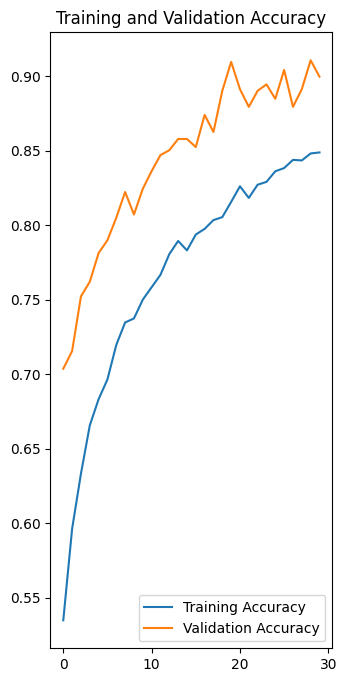

In [30]:
import matplotlib.pyplot as plt
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_' \
'loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [36]:
# Save only weights
model.save_weights("EfficientNet_weights.h5")



In [37]:

model.save("EfficientNet_full_model.h5")


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [40]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

num_classes = 34

# Build model
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Load weights
model.load_weights("EfficientNet_weights.h5", by_name=True, skip_mismatch=True)

# Save as Keras V3 model
model.save("../models/EfficientNet_full_model.keras")
